'## Lec 3. 卷积神经网络 Convolution Neural Network

- 空间不变性 `Spatial Invariance`
- 卷积 `Convolution` -> 互相关运算 `Correlation`

- 具体模型结构
    - Feature Extraction 特征提取：卷积神经网络
    - Classifier 分类器：线性神经网络

### 3.1 互相关运算

In [1]:
import torch
import torch.nn as nn

In [2]:
def corr2d(X, kernel):
    """ 二维互相关运算函数 """
    h_k, w_k = kernel.shape
    h_x, w_x = X.shape
    feature_map = torch.zeros((h_x - h_k + 1, w_x - w_k + 1))

    for i in range(feature_map.shape[0]):
        for j in range(feature_map.shape[1]):
            feature_map[i, j] = (X[i: i + h_k, j: j + w_k] * kernel).sum()
    return feature_map

In [3]:
X = torch.tensor([[0, 1, 2, 3], 
                  [1, 2, 3, 4], 
                  [2, 3, 4, 5], 
                  [3, 4, 5, 6]])

kernel = torch.tensor([[0, 1, 2], 
                       [3, 4, 5], 
                       [6, 7, 8]])

In [4]:
corr2d(X, kernel)

tensor([[ 96., 132.],
        [132., 168.]])

### 3.2 卷积神经网络层的简易实现

In [5]:
def corr2d(X, kernel):
    """ 二维互相关运算函数 """
    h_k, w_k = kernel.shape
    h_x, w_x = X.shape
    feature_map = torch.zeros((h_x - h_k + 1, w_x - w_k + 1))

    for i in range(feature_map.shape[0]):
        for j in range(feature_map.shape[1]):
            feature_map[i, j] = (X[i: i + h_k, j: j + w_k] * kernel).sum()
    return feature_map
    

class Conv2d(nn.Module):
    """ 二维卷积神经网络层 """
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        """ 前向传播方法 """
        feature_map = corr2d(x, self.weight) + self.bias
        return feature_map

In [6]:
conv2d = Conv2d(kernel_size=(3, 3))
conv2d

Conv2d()

In [7]:
feature_map = conv2d(X)
feature_map

tensor([[14.6516, 21.2235],
        [21.2235, 27.7954]], grad_fn=<AddBackward0>)

### 3.3 卷积神经网络的使用

- nn.Conv2d 卷积层模块
- nn.AvgPool2d 池化层模块

In [8]:
model = nn.Conv2d(in_channels=3, out_channels=16, 
                  kernel_size=(2, 2), stride=1, padding=0)

model

Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1))

In [9]:
X.float().view(1, 1, 4, 4).shape  # [batch_size, channels, height, width]

torch.Size([1, 1, 4, 4])

In [10]:
x = torch.rand(1, 3, 4, 4)

model(x).shape  # [batch_size, channels, height, width]

torch.Size([1, 16, 3, 3])

### 3.4 经典卷积神经网络 (LeNet)

- Yann Lecun
- MNIST 手写数字图像识别
    - 逻辑回归、决策树、随机森林
    - 神经网络
        - MLP: Linear
        - CNN: LeNet

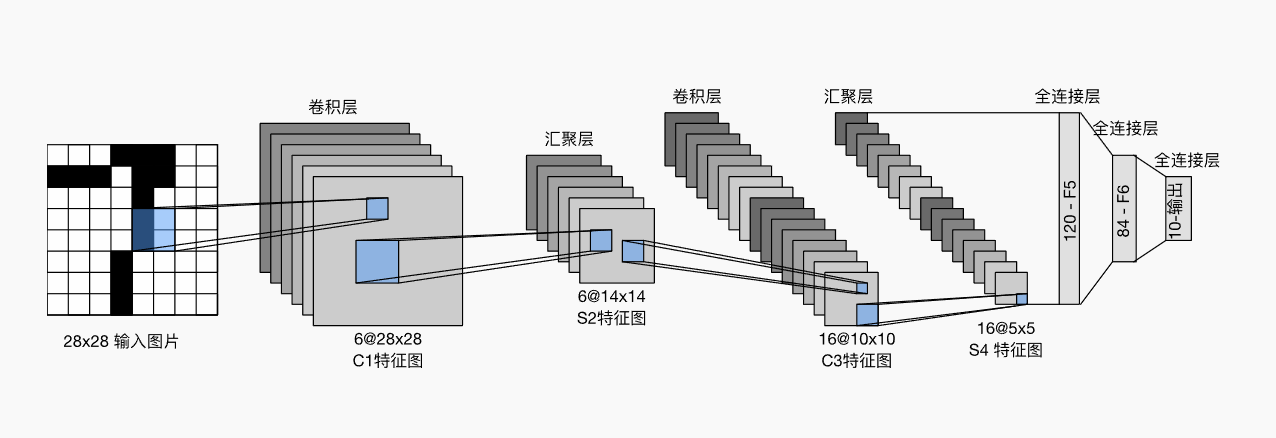

In [11]:
# 1. 构建数据集
import pandas as pd
import torch
import torch.nn as nn
df_dataset = pd.read_csv("E:/文件/fashion-mnist_test.csv")  # 使用相对路径读取CSV文件, 得到DataFrame 数据帧
df_dataset

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,32,23,14,20,0,0,1,0,0,0
9996,6,0,0,0,0,0,0,0,0,0,...,0,0,0,2,52,23,28,0,0,0
9997,8,0,0,0,0,0,0,0,0,0,...,175,172,172,182,199,222,42,0,1,0
9998,8,0,1,3,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [12]:
train_set = df_dataset.sample(frac=0.6)
test_set = df_dataset[~df_dataset.index.isin(train_set.index)]

train_set.shape, test_set.shape

((6000, 785), (4000, 785))

In [13]:
from torch.utils.data import Dataset, DataLoader

class FasionMNIST(Dataset):
    """ FasionMNIST图像识别数据集 """
    def __init__(self, df_dataset):
        self.y = df_dataset.label.values
        self.x = df_dataset.iloc[:, 1:].values

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        y = torch.LongTensor([self.y[idx]])
        x = torch.Tensor(self.x[idx])
        return y, x

In [14]:
train_dataset = FasionMNIST(train_set)
test_dataset = FasionMNIST(test_set)

len(train_dataset), len(test_dataset)

(6000, 4000)

In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256)

len(train_dataloader), len(test_dataloader)

(24, 16)

In [16]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [17]:
# 2. 构建模型
lenet = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5, padding=2), 
                      nn.PReLU(), 
                      nn.AvgPool2d(kernel_size=2, stride=2), 
                      
                      nn.Conv2d(6, 16, kernel_size=5), 
                      nn.Tanh(), 
                      nn.AvgPool2d(kernel_size=2, stride=2), 
                      
                      nn.Flatten(), 
                      nn.Linear(16*5*5, 120), 
                      nn.ReLU(), 
                      
                      nn.Linear(120, 84), 
                      nn.ReLU(),
                      
                      nn.Linear(84, 10))

lenet

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): PReLU(num_parameters=1)
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Tanh()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

In [18]:
# 3. 训练模型
def train_model(model, train_dataloader, optimizer, loss_func):
    """ 训练模型 """
    total_loss = 0.

    model.train() # 打开模型训练模式, 所有参数可以被调整
    for (y, x) in train_dataloader:
        # model input: [batch_size, channels, height, width]
        y_hat = model(x.view(x.shape[0], 1, 28, 28).to(device))
        loss = loss_func(y_hat, y.to(device).view(y.shape[0]))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    print(f"Total loss: {total_loss/len(train_dataloader): 0.4f}")
    model.eval()
    return total_loss/len(train_dataloader)

# 4. 验证模型
def test_model(model, test_dataloader, loss_func):
    """ 训练模型 """
    total_loss = 0.

    model.eval() # 打开模型验证模式，所有参数冻结不可被调整
    for (y, x) in test_dataloader:
        y_hat = model(x.view(x.shape[0], 1, 28, 28).to(device))
        loss = loss_func(y_hat, y.to(device).view(y.shape[0]))
        
        total_loss += loss.item()
    print(f"Total loss: {total_loss/len(test_dataloader): 0.4f}")
    model.train()
    return total_loss/len(test_dataloader)


In [19]:
lenet = nn.Sequential(nn.Conv2d(1, 16, kernel_size=5, padding=2), 
                      nn.PReLU(), 
                      nn.AvgPool2d(kernel_size=2, stride=2), 
                      
                      nn.Conv2d(16, 64, kernel_size=5), 
                      nn.Sigmoid(), 
                      nn.AvgPool2d(kernel_size=2, stride=2), 
                      
                      nn.Conv2d(64, 16, kernel_size=5), 
                      nn.ReLU(), 
                      nn.AvgPool2d(kernel_size=2, stride=2), 
                      
                      nn.Flatten(), 
                      nn.Linear(16*5*5, 120), 
                      nn.Tanh(), 
                      
                      nn.Linear(120, 84), 
                      nn.Sigmoid(),
                      
                      nn.Linear(84, 10)).to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet.parameters(), lr=0.8e-5)

In [20]:
epoch = 1000

train_loss_records = []
test_loss_records = []

lenet = lenet.to(device)

for i in range(epoch):
    train_loss = train_model(lenet, train_dataloader, optimizer, loss_func)
    test_loss = test_model(lenet, test_dataloader, loss_func)
    
    train_loss_records.append(train_loss)
    test_loss_records.append(test_loss)

RuntimeError: Given input size: (16x1x1). Calculated output size: (16x0x0). Output size is too small

In [ ]:
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']= 'True'
plt.figure(figsize=(8, 4))
train_loss_adjusted = [x  for x in train_loss_records]
test_loss_adjusted = [x  for x in test_loss_records]
plt.plot(train_loss_adjusted, label="train loss")
plt.plot(test_loss_adjusted, label="test loss")
#plt.plot(train_loss_records-0.6500, label="train loss")
#plt.plot(test_loss_records-0.6500, label="test loss")
plt.title("LeNet Model Train Loss")
plt.legend()

plt.grid()
plt.show()